# *dandelion* Notebook-1

![dandelion_logo](img/dandelion_logo.png)
## Foreword
***dandelion*** is written in `python==3.7.6` and is primarily a single-cell BCR-seq analysis package. It makes use of some tools from the fantastic [*immcantation suite*](https://immcantation.readthedocs.io/), implementing a workflow to streamline the pre-processing and exploratory stages for analyzing single-cell BCR-seq data from 10X Genomics. Post-processed data from ***dandelion*** can be smoothly transferred to [*scanpy*](https://scanpy.readthedocs.io/)/`AnnData` object for integration and exploration of BCR-seq data and RNA-seq data. I hope to be able to introduce some new single-cell BCR-seq exploratory tools down the road through *dandelion*. 


## Pre-processing
This notebook will cover the initial pre-processing of files after 10X's `cellranger vdj` immune profiling data analysis pipeline. We will download the 10x data sets to process for this tutorial:
```bash
# create sub-folders
mkdir -p dandelion_tutorial/vdj_nextgem_hs_pbmc3
mkdir -p dandelion_tutorial/vdj_v1_hs_pbmc3
mkdir -p dandelion_tutorial/sc5p_v2_hs_PBMC_10k
mkdir -p dandelion_tutorial/sc5p_v2_hs_PBMC_1k

# change into each directory and download the necessary files
cd dandelion_tutorial/vdj_v1_hs_pbmc3;
wget https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.h5;
wget https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_b_filtered_contig_annotations.csv;
wget https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_v1_hs_pbmc3/vdj_v1_hs_pbmc3_b_filtered_contig.fasta;

cd ../vdj_nextgem_hs_pbmc3
wget https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_nextgem_hs_pbmc3/vdj_nextgem_hs_pbmc3_filtered_feature_bc_matrix.h5;
wget https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_nextgem_hs_pbmc3/vdj_nextgem_hs_pbmc3_b_filtered_contig.fasta;
wget https://cf.10xgenomics.com/samples/cell-vdj/3.1.0/vdj_nextgem_hs_pbmc3/vdj_nextgem_hs_pbmc3_b_filtered_contig_annotations.csv;

cd ../sc5p_v2_hs_PBMC_10k;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_filtered_contig_annotations.csv;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_filtered_contig.fasta;

cd ../sc5p_v2_hs_PBMC_1k;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_1k/sc5p_v2_hs_PBMC_1k_filtered_feature_bc_matrix.h5;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_1k/sc5p_v2_hs_PBMC_1k_b_filtered_contig_annotations.csv;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_1k/sc5p_v2_hs_PBMC_1k_b_filtered_contig.fasta;
```

***dandelion*** requires the cellranger fasta files and annotation files to start, particularly either *all_contig.fasta* or *filtered_contig.fasta* and corresponding *all_contig_annotations.csv* and *filtered_contig_annotations.csv*.

In this notebook, I'm running everything with the *filtered_contig* files as a standard analysis set up. I'm using a standard laptop for the analysis here: entry level 2017 Macbook Pro with 2.3 GHz Intel Core i5 processor and 16 GB 2133 MHz LPDDR3 ram.

#### Before starting, a couple of environmental variables should be set up to make it run smoothly:

In ***shell***, export the path to the database folders like as follows:
```bash
# bash/shell
echo "export GERMLINE=/Users/kt16/Documents/Github/dandelion/database/germlines/" >> ~/.bash_profile
echo "export IGDATA=/Users/kt16/Documents/Github/dandelion/database/igblast/" >> ~/.bash_profile
echo "export BLASTDB=/Users/kt16/Documents/Github/dandelion/database/blast/" >> ~/.bash_profile
echo "export PATH=/Users/kt16/Documents/Github/dandelion/bin:$PATH" >> ~/.bash_profile
# reload
source ~/.bash_profile
```
The databases for igblast are basically setup using [changeo's instructions](https://changeo.readthedocs.io/en/stable/examples/igblast.html). The instruction for setting up blast database is simpler and will be covered later in this notebook.

If you followed the installation instructions, you should have the requisite auxillary softwares installed already. Otherwise, you can download them manually: [blast+](https://ftp.ncbi.nih.gov/blast/executables/igblast/release/LATEST/) and [igblast](https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/). For tigger-genotype, you can download it [here](https://bitbucket.org/kleinstein/immcantation/src/default/pipelines/). Just note that I made some minor modifications to this file, hence there is a version that comes with this package.

This notebook will demonstrate how I batch process multiple samples/files from the same donor, as it will become important later on.

In [1]:
# Import modules
import os
os.chdir(os.path.expanduser('/Users/kt16/Documents/Github/dandelion'))
import dandelion as ddl

In [2]:
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
# print current working directory
os.getcwd()

'/Users/kt16/Downloads/dandelion_tutorial'

### Step 1:
#### Formatting the headers of the cellranger fasta file
Here, I'm adding a sample prefix to the headers of each contig in the fasta files using the dictionary created above, via the function `pp.format_fastas`. The prefix is basically just the folder name, so in this case it's `sc5p_v2_hs_PBMC_1k`, `sc5p_v2_hs_PBMC_10k`, `vdj_v1_hs_pbmc3` and `vdj_nextgem_hs_pbmc3`. The function will also create sub-folders where the new fasta file and all subsequent files will be located. The function will also add the prefix to the corresponding annotation file automatically and create a copy in the same folder as the formated fasta file. 

This is to ensure that the barcodes are consistent throughout so as not to interfere with subsequent integration with the gene expression data, which will be covered in notebooks 2 and 3. 

The file structure should look something like this later on if the settings are left as default.
```console
# bash/shell
(dandelion) mib113557i:dandelion_tutorial kt16$ tree sc5p_v2_hs_PBMC_1k
sc5p_v2_hs_PBMC_1k
├── dandelion
│   └── data
│       ├── sc5p_v2_hs_PBMC_1k_b_filtered_contig.fasta
│       ├── sc5p_v2_hs_PBMC_1k_b_filtered_contig_annotations.csv
│       ├── sc5p_v2_hs_PBMC_1k_b_filtered_contig_igblast_gap.tsv
│       ├── sc5p_v2_hs_PBMC_1k_b_filtered_contig_igblast_gap_genotyped.tsv
│       └── tmp
│           ├── sc5p_v2_hs_PBMC_1k_b_filtered_contig_igblast.tsv
│           ├── sc5p_v2_hs_PBMC_1k_b_filtered_contig_igblast_gap.blastsummary.txt
│           └── sc5p_v2_hs_PBMC_1k_b_filtered_contig_igblast_gap.xml
├── sc5p_v2_hs_PBMC_1k_b_filtered_contig.fasta
├── sc5p_v2_hs_PBMC_1k_b_filtered_contig_annotations.csv
└── sc5p_v2_hs_PBMC_1k_filtered_feature_bc_matrix.h5
```

The first option of `pp.format_fastas` is a list of the fasta files to reformat, or list of names of folders containing the fasta files; each folder should only contain 1 fasta file, and 1 contig_annotation.csv. You can provide a list of `prefix` and/or `suffix` to add the the cell/contig barcodes (note that contig barcodes are handled slightly differently), separated by a string specified via `sep`. If you choose not to provide a prefix/suffix, then the function will simply make a copy of the original files and place it in the sub-folders.

In [3]:
# the first option is a list of fasta files to format and the second option is the list of prefix to add to each file.
samples = ['sc5p_v2_hs_PBMC_1k', 'sc5p_v2_hs_PBMC_10k', 'vdj_v1_hs_pbmc3', 'vdj_nextgem_hs_pbmc3']
ddl.pp.format_fastas(samples, prefix = samples)

Formating fasta(s) : 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


### Step 2:
#### Reannotate the V/D/J genes with *igblastn*.

`pp.reannotate_genes` uses [*changeo*](https://changeo.readthedocs.io/en/stable/examples/10x.html)'s `AssignGenes.py` and `MakeDB.py` to call *igblastn* to reannotate the fasta files. With the recent update to changeo v1.0.0, all the column headers are now adhereing to the [*AIRR*](http://docs.airr-community.org/) standard.

In [4]:
ddl.pp.reannotate_genes(samples)

Assigning genes : 100%|██████████| 4/4 [06:53<00:00, 103.47s/it]


### Step 3:
#### Assigning constant region calls

10X's annotation files provides a *c_gene* column, but rather than simply relying on 10x's annotation, [hk6](https://twitter.com/hamish_king) recommended using [*immcantation-presto*'s *MaskPrimers.py*](https://presto.readthedocs.io/en/version-0.5.3---license-change/tools/MaskPrimers.html) with his custom primer list. I tested that and while it worked well, preliminary tests suggest that it takes a long time to run (***20 min*** for ~6k contigs on a standard laptop). It also only calls the constant region for the heavy chains. 

Anyway, as an alternative, I wrote a pre-processing function, `pp.assign_isotypes`, to use *blast* to annotate constant region calls for all contigs and retrieves the call, merging it with the tsv files. This function will simply overwrite the output from previous steps and add a *c_call* column at the end, or replace the existing column if it already exists.

Further, to deal with incorrect constant gene calls due to insufficient length, an internal subfunction will run a pairwise alignment against [hk6](https://twitter.com/hamish_king)'s curated sequences that were deemed to be highly specific in distinguishing IGHA1-2, IGHG1-4. I have also curated sets of sequences that should help deal with IGLC3/6/7 as these are problematic too. If there is insufficient info, the `c_call` will be returned as a combination of the most aligned sets of sequences. Because of how similar the lambda light chains are, extremely ambiguous calls (only able to map to a common sequence across the light chains) will be returned as `IGLC`. This typically occurs when the constant sequence is very short. Those that have equal alignment scores between `IGLC3/6/7` sequences and the common sequence will be returned as a concatenated call; for example, a contig initially annotated as `IGLC3` will be returned as `IGLC,IGLC3`. If you do not want this subfunction to run, toggle:

```python
correct_c_call = False
```

The curated sequences can be replaced with a dict-of-dict-of-dict style dictionary via the option `correction_dict`. The provided dictionary should be a nested dictionary like the following:
```python
primer_dict = {
    'IGHG':{
        'IGHG1':'GCCTCCACCAAGGGCCCATCGGTCTTCCCCCTGGCACCCTCCTCCAAGAGCACCTCTGGGGGCACAGCGGCCCTGGGC',
        'IGHG2':'GCCTCCACCAAGGGCCCATCGGTCTTCCCCCTGGCGCCCTGCTCCAGGAGCACCTCCGAGAGCACAGCGGCCCTGGGC',
        'IGHG3':'GCTTCCACCAAGGGCCCATCGGTCTTCCCCCTGGCGCCCTGCTCCAGGAGCACCTCTGGGGGCACAGCGGCCCTGGGC',
        'IGHG4':'GCTTCCACCAAGGGCCCATCCGTCTTCCCCCTGGCGCCCTGCTCCAGGAGCACCTCCGAGAGCACAGCCGCCCTGGGC'}}
```

The key for the first level of the dictionary is used like a grep for searching whether the string pattern exists in the `c_call`, and the second level holds the dictionary for the the sequences to align to. The keys in the second level are used for replacing the existing `c_call` annotation if it is returned with the highest alignment score. The internal function currently only accepts nested dictionaries of any length with a requirement that each of the dictionaries in the second level must be of length 2 to 4; the example above is a nested dictionary of length 1 in the first level, with a dictionary of length 4 in the second level.

==========================

Before running, there is a need to set up a database with IMGT constant gene fasta sequences using *makeblastdb*,
basically following the instructions from https://www.ncbi.nlm.nih.gov/books/NBK279688/. ***This only needs to be done once.***

The fasta files were downloaded from IMGT and only sequences corresponding to *CH1* region for each constant gene/allele were retained. The headers were trimmed to only keep the gene and allele information. Links to find the sequences can be found here : [***human***](http://www.imgt.org/genedb/GENElect?query=7.2+IGHC&species=Homo+sapiens) and [***mouse***](http://www.imgt.org/genedb/GENElect?query=7.2+IGHC&species=Mus).

The database file is provided in the repository and I've written a utility function `utl.makeblastdb` to prep new fasta files/databases if you need to.
```python
ddl.utl.makeblastdb('/location/of/folder/corresponding/to/database/blast/human/human_BCR_C.fasta')
```

**Again, we really only need to do it once**; the file path can be added as an environmental variable after running:
```bash
# bash/shell
echo "export BLASTDB=/location/of/folder/corresponding/to/dandelion/database/blast/" >> ~/.bash_profile
source ~/.bash_profile
```

I've set it up so that if the default option for `blastdb` is left as `None`, the function will retrieve a relative path from you terminal's environmental variable `$BLASTDB` and then, depending on which organism was specified `(default = human)`, point to the correct fasta file. If you choose not to add it to environment, you can provide a string specifying a path to the fasta file for the `blastdb` option. The string has to point directly to the fasta file, i.e. ends with `.fasta`.

==========================

In [5]:
# ddl.utl.makeblastdb('/Users/kt16/Documents/Github/dandelion/database/blast/human_BCR_C.fasta')

Retrieving contant region calls, parallelizing with 3 cpus : 100%|██████████| 202/202 [00:00<00:00, 301.11it/s]


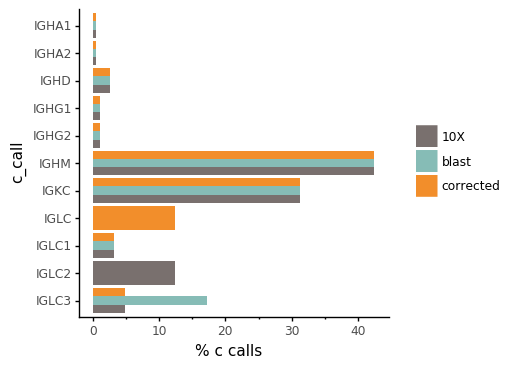

<ggplot: (330691689)>


Retrieving contant region calls, parallelizing with 3 cpus : 100%|██████████| 2601/2601 [00:33<00:00, 76.67it/s]


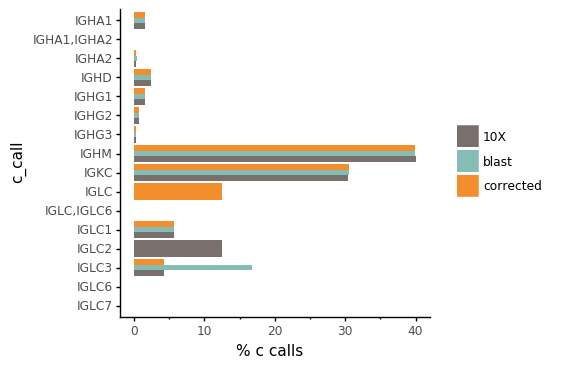

<ggplot: (327994373)>


Retrieving contant region calls, parallelizing with 3 cpus : 100%|██████████| 2059/2059 [00:18<00:00, 111.11it/s]


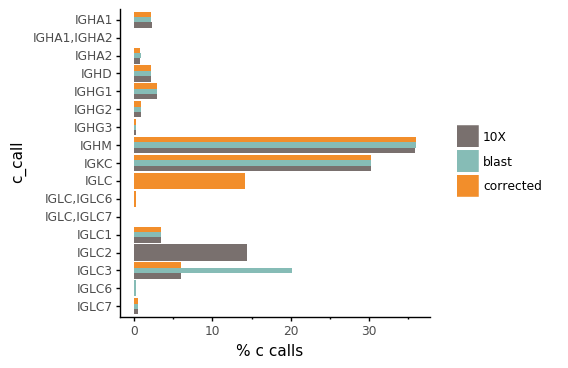

<ggplot: (330494257)>


Retrieving contant region calls, parallelizing with 3 cpus : 100%|██████████| 3222/3222 [00:48<00:00, 66.15it/s]


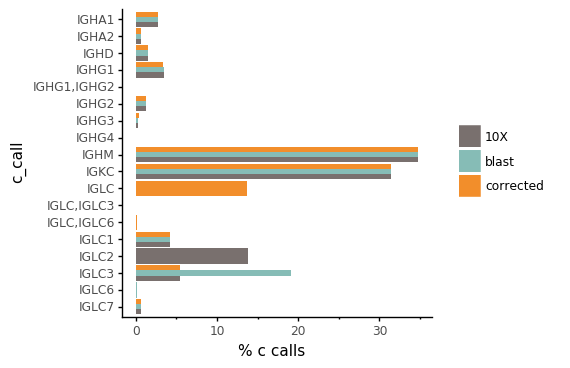

<ggplot: (328025913)>


In [6]:
ddl.pp.assign_isotypes(samples)

This still takes a while when dealing with large files; the number of cpus to size of file isn't exactly linear. Nevertheless, I have enabled parallelization as default because there were noticeable improvements in processing speeds with the smaller files. Maybe it will work better on a cluster with more cpus, rather than just a standard laptop. The default option will return a summary plot that can be disabled with `plot = False`.

It's worthwhile to manually check the the sequences for constant calls returned as IGHA1-2, IGHG1-4 and the light chains and manually correct them if necessary.

### Step 4 *(optional but recommended)*:
#### Reassigning heavy chain V gene alleles.

Next, we use *immcantation's TIgGER* method to reassign allelic calls for heavy chain V genes with `pp.reassign_alleles`. As stated in TIgGER's [website](https://tigger.readthedocs.io/en/stable/) and [manuscript](https://pubmed.ncbi.nlm.nih.gov/25675496/), *'TIgGER is a computational method that significantly improves V(D)J allele assignments by first determining the complete set of gene segments carried by an individual (including novel alleles) from V(D)J-rearrange sequences. TIgGER can then infer a subject’s genotype from these sequences, and use this genotype to correct the initial V(D)J allele assignments.'*

This impacts on how contigs are chosen for finding clones later. It is also important when considering to do mutational analysis. Therefore, it is highly recommended to run it. 

However, the main caveat is that this will only work properly if there is sufficient contigs/reads. An ideal scenario would be to run it on multiple samples from the same subject to allow for more information to be used to confidently assign a genotyped *v_call*. In this tutorial, I'm assuming the four samples can be split into two sets where sets of two corresponds to a different/single individual. So while important, this step can be skipped if you don't have enough data to do this. 

`pp.reassign_alleles` requires the `combined_folder` option to be specified so that a merged/concatenated file can be produced for running TIgGER. The function also runs `pp.create_germlines` using the germline database updated with the germline corrections from TIgGER. The default behavior is that it will return a `germline_alignment_d_mask` column in the final output. This can be changed by specifying `germ_types` option; see [here](https://changeo.readthedocs.io/en/stable/tools/CreateGermlines.html#creategermlines) for other options.

Processing data file(s) : 100%|██████████| 2/2 [00:00<00:00, 11.74it/s]

Concatenating objects
   Writing out concatenated object


      Reassigning alleles


   Returning light chain V calls: 100%|██████████| 2612/2612 [00:00<00:00, 57581.54it/s]
   Building dmask germline sequences: 2612it [00:08, 297.95it/s]


   Saving corrected genotyped object
Returning summary plot


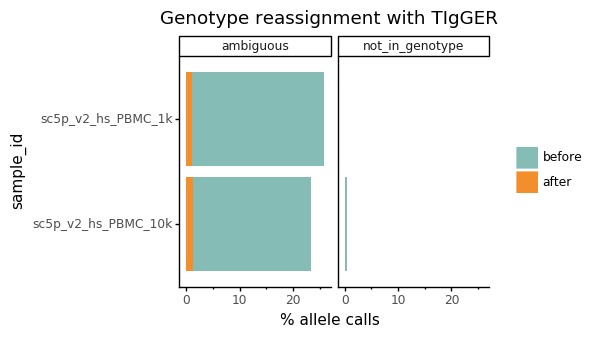

<ggplot: (334173777)>


Writing out to individual folders : 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


In [7]:
# reassigning alleles on the first set of samples
ddl.pp.reassign_alleles(samples[:2], combined_folder = 'tutorial_scgp1')

Processing data file(s) : 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


Concatenating objects
   Writing out concatenated object
      Reassigning alleles


   Returning light chain V calls: 100%|██████████| 4900/4900 [00:00<00:00, 50420.35it/s]
   Building dmask germline sequences: 4900it [00:09, 530.59it/s]


   Saving corrected genotyped object
Returning summary plot


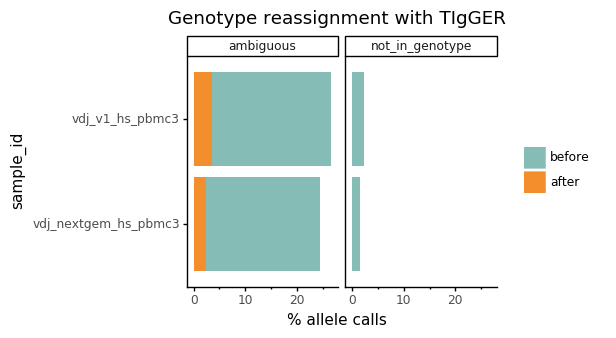

<ggplot: (332984381)>


Writing out to individual folders : 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


In [8]:
# reassigning alleles on the second set of samples
ddl.pp.reassign_alleles(samples[2:], combined_folder = 'tutorial_scgp2')

We can see that most of the original ambiguous V calls have now been corrected and only a few remain. These will be flagged as multi later on and can probably be excluded from detailed analyses. For now, leaving them in the data will not impact on subsequent analyses. 

### Step 5:
#### Quantify mutations *(optional)*.

At this stage, with all the necessary columns in the files, you can quantify the basic mutational load with `pp.quantify_mutations` before subsequent analyses. This will be covered again in notebook-3.

In [9]:
from tqdm import tqdm
# quantify mutations
for s in tqdm(samples, desc = 'Basic mutational load analysis '):
    filePath = s+'/dandelion/data/'+ s + '_b_filtered_contig_igblast_db-pass_genotyped.tsv'
    ddl.pp.quantify_mutations(filePath)

Basic mutational load analysis : 100%|██████████| 4/4 [00:40<00:00, 10.14s/it]
